In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# 1. Importing necessary library:-

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import iplot
import re 
from textblob import TextBlob 
from wordcloud import WordCloud
import random
import string
import nltk
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
from nltk.tokenize import sent_tokenize
import gensim.downloader as api
import sys
sys.path.append('/content/gdrive/MyDrive/CE807/Assignment2/2205233')
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import Input, Dense, Dropout,Embedding, Bidirectional, LSTM, Dense, GlobalAveragePooling1D,Conv1D,MaxPool1D,Flatten,Reshape,GlobalMaxPooling1D
from keras.models import Model,Sequential
from keras.optimizers import Adam ,SGD ,  RMSprop
from preprocessing import TextPreprocessor
from keras.callbacks import History,ModelCheckpoint 
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import pickle
import warnings
warnings.filterwarnings('ignore')
from keras import regularizers
from keras import backend as K
from keras.metrics import  Precision,Recall
import joblib

In [7]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

------------- Reading the Dataset's -------------------

In [8]:
train = pd.read_csv("/content/gdrive/MyDrive/CE807/Assignment2/2205233/train.csv")
test = pd.read_csv("/content/gdrive/MyDrive/CE807/Assignment2/2205233/test.csv")
valid = pd.read_csv("/content/gdrive/MyDrive/CE807/Assignment2/2205233/valid.csv")


In [9]:
train

,id,tweet,label
0,42884,@USER I’m done with you as well. An INTENTIONA...,NOT
1,92152,I now have over 6k followers. Only 94k to go ...,NOT
2,65475,@USER Tom was bought! He is more interested in...,NOT
3,22144,@USER @USER Even her brother thinks she is a m...,OFF
4,81048,@USER @USER @USER @USER @USER I can understand...,OFF
...,...,...,...
12308,92805,And Soros money in their pocket. #maga🇺🇸🇺🇸🇺🇸🇺🇸...,NOT
12309,35989,@USER ur a fucking dumbass fr. there’s no way ...,OFF
12310,30188,.@USER They both want you to believe in yourse...,NOT
12311,96815,@USER It's like a reading a leaflet from Antif...,OFF


In [ ]:
valid

,id,tweet,label
0,12476,@USER @USER @USER Trump is declassifying infor...,NOT
1,23242,@USER Ha even with them trying to rig the syst...,NOT
2,97885,@USER @USER @USER Man you really thought this ...,NOT
3,43414,@USER Ms. Clinton - you are a class act. My re...,OFF
4,81403,@USER It’s still here at 753. If someone did t...,NOT
...,...,...,...
922,22519,@USER @USER She is as dumb as she looks,OFF
923,58715,@USER If you cant give me stitches when I get ...,NOT
924,46544,@USER need more ladies to spread out their pus...,OFF
925,70368,@USER I cant believe he didnt work in comet pi...,OFF


In [ ]:
train['label'].unique()

array(['NOT', 'OFF'], dtype=object)

# 2.Splitting the data into given size 25,50,75,100 percentage

In [ ]:
from split_data import split_data

train_25,train_50,train_75,train_100 = split_data(data=train)




Size of train_25: 25.00% Lenght of train_25: 3078
Size of train_50: 50.00% Lenght of train_50: 6156
Size of train_75: 75.00% Lenght of train_75: 9235
Size of train_100: 100.00% Lenght of train_100: 12313


In [ ]:
train_25.to_csv("/content/gdrive/MyDrive/CE807/Assignment2/2205233/train_25.csv")
train_50.to_csv("/content/gdrive/MyDrive/CE807/Assignment2/2205233/train_50.csv")
train_75.to_csv("/content/gdrive/MyDrive/CE807/Assignment2/2205233/train_75.csv")
train_100.to_csv("/content/gdrive/MyDrive/CE807/Assignment2/2205233/train_100.csv")
tqdm(test.to_csv("/content/gdrive/MyDrive/CE807/Assignment2/2205233/Test.csv"))
tqdm(valid.to_csv("/content/gdrive/MyDrive/CE807/Assignment2/2205233/Valid.csv"))

0it [00:00, ?it/s]
0it [00:00, ?it/s]

# 3. Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

def compute_performance(y_true, y_pred):
    """
    Prints different performance metrics like Accuracy, Recall (macro), Precision (macro), and F1 (macro).
    This also displays Confusion Matrix with proper X & Y axis labels.
    Also, returns F1 score.

    Args:
        y_true: numpy array or list
        y_pred: numpy array or list

    Returns:
        float
    """
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    return f1,acc,recall,precision,cm



def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('Epochs',fontsize=16)
        ax[idx].set_ylabel(' ',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

# Method 1 :- Convolutional Neural Networks for Sentence Classification by Yoon Kim




# Model Architecture Initialization



In [ ]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = os.path.join('./CE807/Assignment2/',str(2205233)) # Make sure to update with your student_id and student_id is an integer
GOOGLE_DRIVE_PATH = os.path.join('gdrive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print('List files: ', os.listdir(GOOGLE_DRIVE_PATH))

train_file = os.path.join(GOOGLE_DRIVE_PATH, 'train.csv')
print('Train file: ', train_file)

MODEL_1_DIRECTORY = os.path.join(GOOGLE_DRIVE_PATH, 'models', '1') # Model 1 directory
print('Model 1 directory: ', MODEL_1_DIRECTORY)

MODEL_1_25_DIRECTORY = os.path.join(MODEL_1_DIRECTORY,'25') # Model 1 trained using 25% of train data directory
print('Model 1 directory with 25% data: ', MODEL_1_25_DIRECTORY)

model_1_25_output_test_file = os.path.join(MODEL_1_25_DIRECTORY, 'output_test.csv') # Output file using Model 1 trained using 25% of train data 
print('Output file name using model 1 using 25% of train data: ',model_1_25_output_test_file)

MODEL_1_50_DIRECTORY = os.path.join(MODEL_1_DIRECTORY,'50') # Model 1 trained using 50% of train data directory
print('Model 1 directory with 50% data: ', MODEL_1_50_DIRECTORY)

model_1_50_output_test_file = os.path.join(MODEL_1_50_DIRECTORY, 'output_test.csv') # Output file using Model 1 trained using 50% of train data 
print('Output file name using model 1 using 50% of train data: ',model_1_50_output_test_file)

MODEL_1_75_DIRECTORY = os.path.join(MODEL_1_DIRECTORY,'75') # Model 1 trained using 75% of train data directory
print('Model 1 directory with 75% data: ', MODEL_1_75_DIRECTORY)

model_1_75_output_test_file = os.path.join(MODEL_1_75_DIRECTORY, 'output_test.csv') # Output file using Model 1 trained using 75% of train data 
print('Output file name using model 1 using 75% of train data: ',model_1_75_output_test_file)

MODEL_1_100_DIRECTORY = os.path.join(MODEL_1_DIRECTORY,'100') # Model 1 trained using 100% of train data directory
print('Model 1 directory with 100% data: ', MODEL_1_100_DIRECTORY)

model_1_100_output_test_file = os.path.join(MODEL_1_100_DIRECTORY, 'output_test.csv') # Output file using Model 1 trained using 100% of train data 
print('Output file name using model 1 using 100% of train data: ',model_1_100_output_test_file)

List files:  ['Code.ipynb', 'valid.csv', 'train.csv', 'test.csv', 'glove.6B', '__pycache__', 'Model1', 'split_data.py', '.ipynb_checkpoints', 'GoogleNews-vectors-negative300.bin.gz', 'Model2', 'preprocessing.py', 'Copy of Code.ipynb', 'train_25.csv', 'train_50.csv', 'train_75.csv', 'train_100.csv', 'Test.csv', 'Valid.csv', 'CE807 Assignment 2.gslides']
Train file:  gdrive/MyDrive/./CE807/Assignment2/2205233/train.csv
Model 1 directory:  gdrive/MyDrive/./CE807/Assignment2/2205233/models/1
Model 1 directory with 25% data:  gdrive/MyDrive/./CE807/Assignment2/2205233/models/1/25
Output file name using model 1 using 25% of train data:  gdrive/MyDrive/./CE807/Assignment2/2205233/models/1/25/output_test.csv
Model 1 directory with 50% data:  gdrive/MyDrive/./CE807/Assignment2/2205233/models/1/50
Output file name using model 1 using 50% of train data:  gdrive/MyDrive/./CE807/Assignment2/2205233/models/1/50/output_test.csv
Model 1 directory with 75% data:  gdrive/MyDrive/./CE807/Assignment2/2205

In [ ]:
def train_method1(train_file, val_file, model_dir):
    """
     Takes train_file, val_file and model_dir as input.
     It trained on the train_file datapoints, and validate on the val_file datapoints.
     While training and validating, it print different evaluataion metrics and losses, wheverever necessary.
     After finishing the training, it saved the best model in the model_dir.

     ADD Other arguments, if needed.

    Args:
        train_file: Train file name
        val_file: Validation file name
        model_dir: Model output Directory

    Returns:
        None
    
    from keras.layers import SpatialDropout1D
    
    """
    #Load train and validation data
    train_data = pd.read_csv(train_file)
    valid_data = pd.read_csv(val_file)
    

    preprocessor = TextPreprocessor()
    train_data = preprocessor.preprocess_dataframe(train_data)
    train_data = preprocessor.map(train_data)
    #train['tweet'] = preprocessor.remove_duplicate_words(train)
   
    
    ##-----valid----##
    valid_data = preprocessor.preprocess_dataframe(valid_data)
    valid_data = preprocessor.map(valid_data)
    #valid['tweet'] = preprocessor.remove_duplicate_words

    train_data = train_data.drop(['id',],axis=True)
    valid_data = valid_data.drop(['id',],axis=True)
    

    # Convert tweets to padded sequences
    tokenizer = Tokenizer(num_words=1000000)
    tokenizer.fit_on_texts(train_data['tweet'])
    word_index = tokenizer.word_index
    vocab_size = len(word_index)
    print(f'Vocabulary size: {vocab_size}')
    word_vectors = KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/CE807/Assignment2/2205233/GoogleNews-vectors-negative300.bin.gz', binary=True, limit=vocab_size+1)
    X_train = tokenizer.texts_to_sequences(train_data['tweet'])
    X_valid = tokenizer.texts_to_sequences(valid_data['tweet'])
    X_train = pad_sequences(X_train, maxlen=300, padding='post')
    X_valid = pad_sequences(X_valid, maxlen=300, padding='post')
    
    # Convert labels to numpy arrays
    y_train = np.array(train_data['label'])
    y_valid = np.array(valid_data['label'])



    # Build CNN-static model
    model = Sequential()    
    model.add(Embedding(input_dim=vocab_size + 1,
                    output_dim=word_vectors.vector_size,
                    weights=[word_vectors.vectors],
                    input_length=300,
                    trainable=False))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile model
    def f1_score(y_true, y_pred): #taken from old keras source code
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      recall = true_positives / (possible_positives + K.epsilon())
      f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
      return f1_val
    

    # Compile model with F1-score metric
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

  

    # Train model
    history = History()
    f1_score = model.fit(tf.expand_dims(X_train,axis=-1), y_train, epochs=10, batch_size= 128, validation_data=(X_valid, y_valid), callbacks=[history])

    plot_learning_curves(history, [['loss', 'val_loss'],['f1_score', 'val_f1_score']])



    # save model
    joblib.dump(model, model_dir + '/model.sav')
    print(f'model saved to : {model_dir}')
    
    return model,f1_score

In [ ]:
import pandas as pd
import numpy as np
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

def test_method1(test_file, model_file, output_dir):
    """
    Load a trained model and evaluate it on a test set, then save the output to a file.

    Args:
        test_file (str): The path to the CSV file containing the test data.
        model_file (str): The path to the saved Keras model file.
        output_dir (str): The path to the directory where the output file should be saved.
    """
    ## Load the test data and model
    test_data = pd.read_csv(test_file)
    ##-----test----##
    preprocessor = TextPreprocessor()
    test_data = preprocessor.preprocess_dataframe(test_data)
    test_data = preprocessor.map(test_data)

    #test['tweet'] = preprocessor.remove_duplicate_words
    test_data = test_data.drop(['id',],axis=True)
    # Convert tweets to padded sequences
    tokenizer = Tokenizer(num_words=100000)
    tokenizer.fit_on_texts(test_data['tweet'])
    word_index = tokenizer.word_index
    X_test = tokenizer.texts_to_sequences(test_data['tweet'])
    X_test = pad_sequences(X_test, maxlen=300, padding='post')
    # Convert labels to numpy arrays
    y_test = np.array(test_data['label'])
    joblib.dump(word_index, output_dir + '/Vectorizer.sav')
    print(f'Vector saved to : {output_dir}')

    model = joblib.load(model_file)
    print(f'Model loaded from: {model_dir}')

    # Generate predictions on the test data
    y_pred_prob = model.predict(X_test)
    y_pred = np.round(y_pred_prob).flatten()
    compute_performance(y_test, y_pred)

    # Print the classification report
    print(classification_report(y_test, y_pred))
  
    # Save the output to a file
    test_data['out_label'] = y_pred
    mapping = {1.0: 'NOT', 0.0: 'OFF'}
    test_data['out_label'] = test_data['out_label'].apply(lambda x: mapping[x])
    test_data['label'] = test_data['label'].apply(lambda x: mapping[x])
    test_data.to_csv(output_dir+'/output_test.csv', index=False)
    print(f'Output saved to : {output_dir}/output_test.csv')

Training the model using 25% of data i.e. train_25 & Valid file 
---



Vocabulary size: 8046
Epoch 1/10
25/25 [==============================] - 2s 27ms/step - loss: 0.6430 - accuracy: 0.6605 - f1_score: 0.7824 - val_loss: 0.6339 - val_accuracy: 0.6688 - val_f1_score: 0.7937
Epoch 2/10
25/25 [==============================] - 0s 17ms/step - loss: 0.5815 - accuracy: 0.7135 - f1_score: 0.8240 - val_loss: 0.6377 - val_accuracy: 0.6677 - val_f1_score: 0.7930
Epoch 3/10
25/25 [==============================] - 0s 15ms/step - loss: 0.4952 - accuracy: 0.7703 - f1_score: 0.8581 - val_loss: 0.6415 - val_accuracy: 0.6796 - val_f1_score: 0.7972
Epoch 4/10
25/25 [==============================] - 0s 17ms/step - loss: 0.3668 - accuracy: 0.8687 - f1_score: 0.9065 - val_loss: 0.6365 - val_accuracy: 0.6580 - val_f1_score: 0.7568
Epoch 5/10
25/25 [==============================] - 0s 16ms/step - loss: 0.2345 - accuracy: 0.9461 - f1_score: 0.9578 - val_loss: 0.7414 - val_accuracy: 0.6882 - val_f1_score: 0.7954
Epoch 6/10
25/25 [==============================] - 0s 15ms/ste

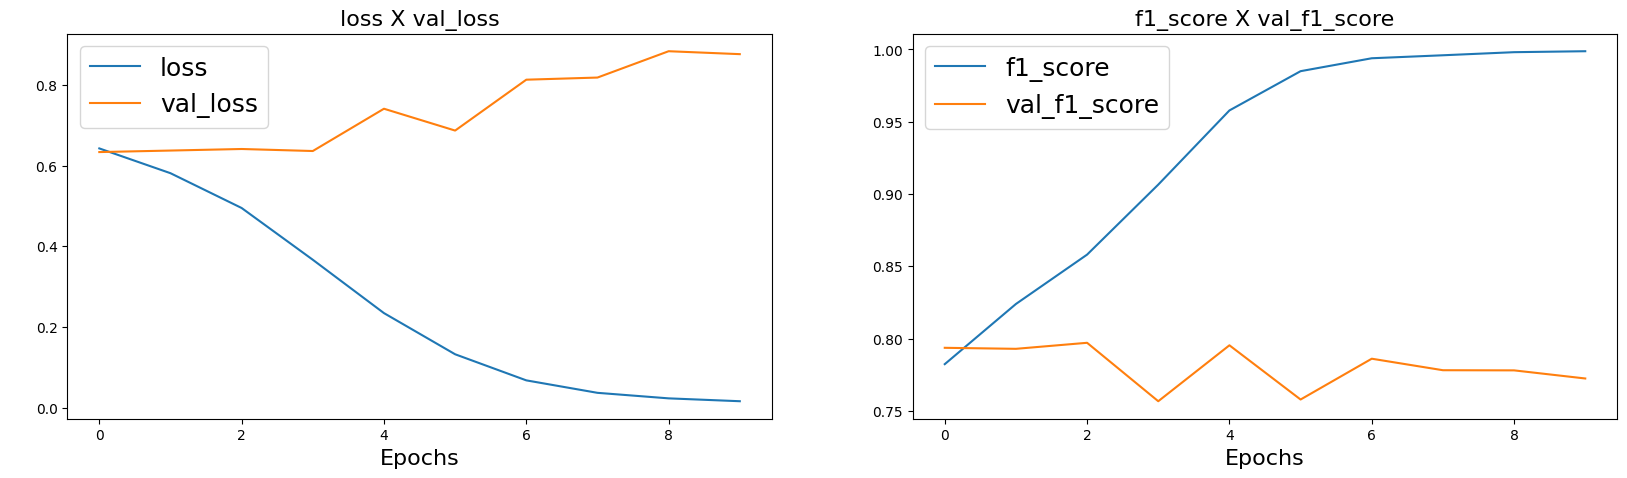

In [ ]:
train_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/train_25.csv"
valid_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/valid.csv"
model_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/25/"

model = train_method1(train_file=train_file,val_file=valid_file,model_dir=model_dir)

In [ ]:
test_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/test.csv"
model_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/25/model.sav"
output_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/25"


test_method1(test_file=test_file,model_file=model_file,output_dir=output_dir)

Vector saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/25
Model loaded from: /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/25/
27/27 [==============================] - 0s 3ms/step
Accuracy: 0.6384
Recall: 0.5079
Precision: 0.5098
F1-score: 0.5045
Confusion Matrix:
 [[ 51 189]
 [122 498]]
              precision    recall  f1-score   support

           0       0.29      0.21      0.25       240
           1       0.72      0.80      0.76       620

    accuracy                           0.64       860
   macro avg       0.51      0.51      0.50       860
weighted avg       0.60      0.64      0.62       860

Output saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/25/output_test.csv


# Training the model using 50% of data i.e. train_50 & Valid file


Vocabulary size: 12125
Epoch 1/10
49/49 [==============================] - 2s 22ms/step - loss: 0.6320 - accuracy: 0.6662 - f1_score: 0.7996 - val_loss: 0.6197 - val_accuracy: 0.6710 - val_f1_score: 0.7947
Epoch 2/10
49/49 [==============================] - 1s 15ms/step - loss: 0.5326 - accuracy: 0.7393 - f1_score: 0.8330 - val_loss: 0.5971 - val_accuracy: 0.7055 - val_f1_score: 0.8013
Epoch 3/10
49/49 [==============================] - 1s 15ms/step - loss: 0.3503 - accuracy: 0.8736 - f1_score: 0.9106 - val_loss: 0.6236 - val_accuracy: 0.6990 - val_f1_score: 0.7882
Epoch 4/10
49/49 [==============================] - 1s 18ms/step - loss: 0.1573 - accuracy: 0.9620 - f1_score: 0.9703 - val_loss: 0.6786 - val_accuracy: 0.6969 - val_f1_score: 0.7925
Epoch 5/10
49/49 [==============================] - 1s 17ms/step - loss: 0.0679 - accuracy: 0.9877 - f1_score: 0.9909 - val_loss: 0.7733 - val_accuracy: 0.6947 - val_f1_score: 0.7864
Epoch 6/10
49/49 [==============================] - 1s 16ms/st

(<keras.engine.sequential.Sequential at 0x7f5820214be0>,
 <keras.callbacks.History at 0x7f58d6b9a9d0>)

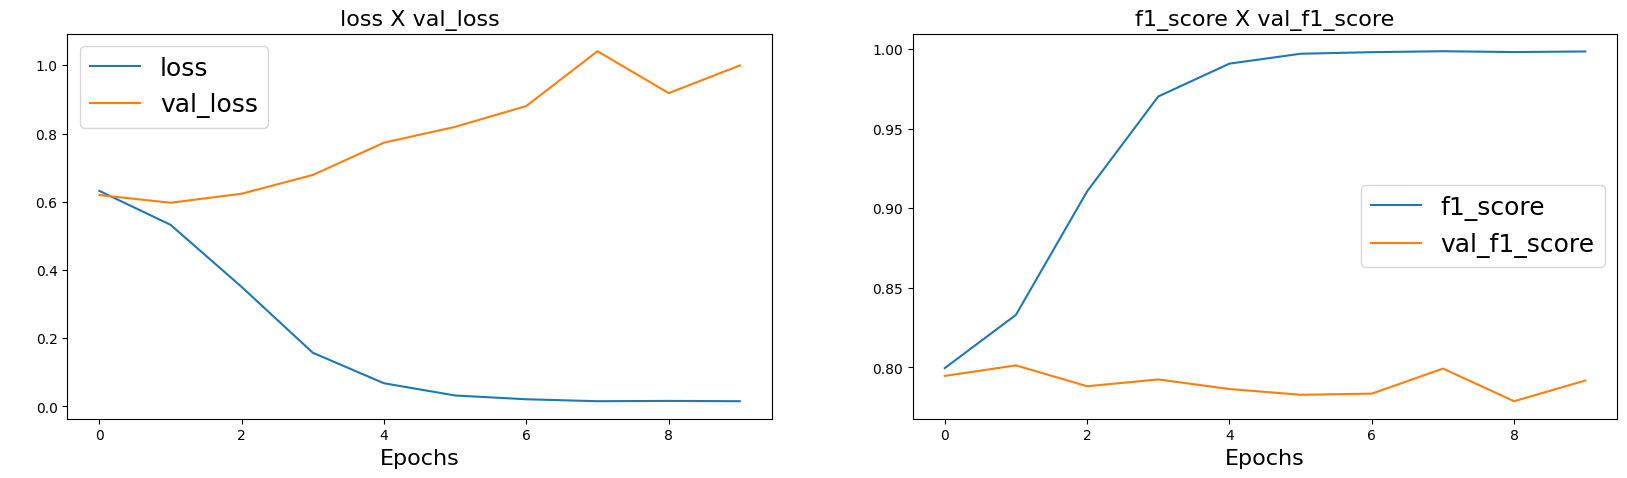

In [ ]:
train_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/train_50.csv"
valid_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/valid.csv"
model_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/50/"

train_method1(train_file=train_file,val_file=valid_file,model_dir=model_dir)

In [ ]:
test_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/test.csv"
model_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/50/model.sav"
output_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/50"


test_method1(test_file=test_file,model_file=model_file,output_dir=output_dir)

Vector saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/50
Model loaded from: /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/50/
27/27 [==============================] - 0s 3ms/step
Accuracy: 0.5872
Recall: 0.4711
Precision: 0.4690
F1-score: 0.4696
Confusion Matrix:
 [[ 50 190]
 [165 455]]
              precision    recall  f1-score   support

           0       0.23      0.21      0.22       240
           1       0.71      0.73      0.72       620

    accuracy                           0.59       860
   macro avg       0.47      0.47      0.47       860
weighted avg       0.57      0.59      0.58       860

Output saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/50/output_test.csv


# Training the model using 75% of data i.e. train_75 & Valid file

---




Vocabulary size: 15322
Epoch 1/10
73/73 [==============================] - 3s 24ms/step - loss: 0.6294 - accuracy: 0.6636 - f1_score: 0.7890 - val_loss: 0.6401 - val_accuracy: 0.6699 - val_f1_score: 0.7942
Epoch 2/10
73/73 [==============================] - 1s 17ms/step - loss: 0.5246 - accuracy: 0.7460 - f1_score: 0.8342 - val_loss: 0.6009 - val_accuracy: 0.7077 - val_f1_score: 0.8019
Epoch 3/10
73/73 [==============================] - 1s 15ms/step - loss: 0.3275 - accuracy: 0.8770 - f1_score: 0.9125 - val_loss: 0.6293 - val_accuracy: 0.6828 - val_f1_score: 0.7595
Epoch 4/10
73/73 [==============================] - 1s 17ms/step - loss: 0.1355 - accuracy: 0.9686 - f1_score: 0.9765 - val_loss: 0.7582 - val_accuracy: 0.7109 - val_f1_score: 0.7971
Epoch 5/10
73/73 [==============================] - 2s 22ms/step - loss: 0.0654 - accuracy: 0.9899 - f1_score: 0.9925 - val_loss: 0.8109 - val_accuracy: 0.7120 - val_f1_score: 0.7925
Epoch 6/10
73/73 [==============================] - 1s 18ms/st

(<keras.engine.sequential.Sequential at 0x7f58d68af5e0>,
 <keras.callbacks.History at 0x7f58d6ba13a0>)

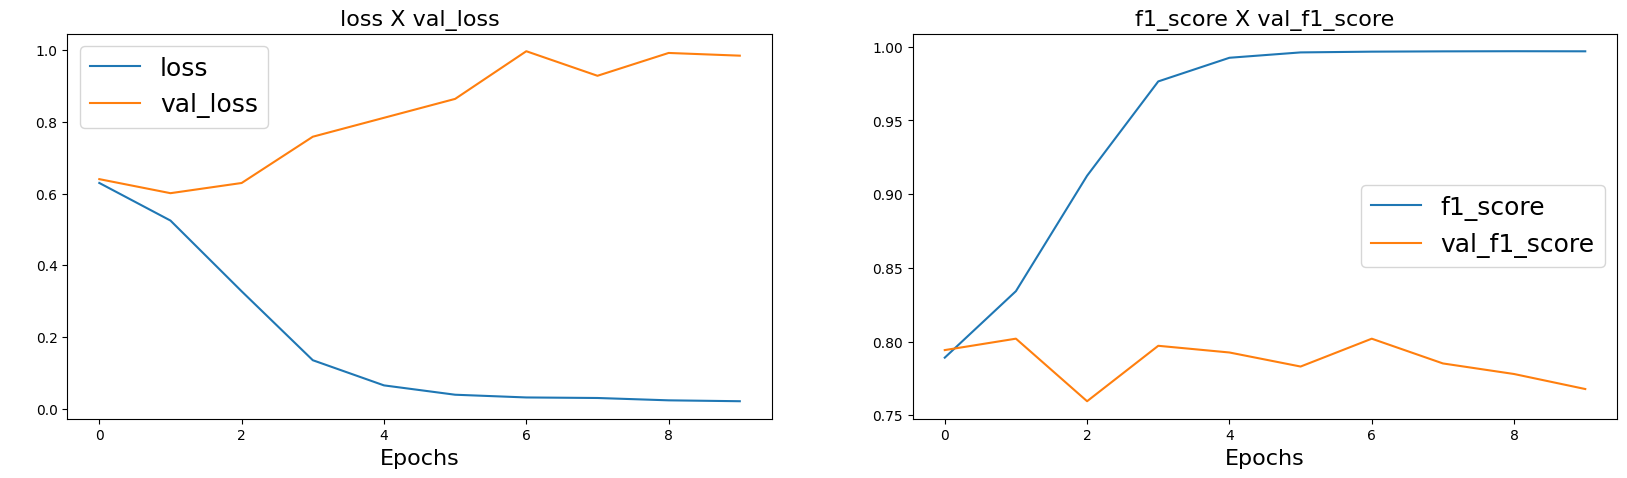

In [ ]:
train_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/train_75.csv"
valid_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/valid.csv"
model_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/75/"

train_method1(train_file=train_file,val_file=valid_file,model_dir=model_dir)

In [ ]:
test_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/test.csv"
model_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/75/model.sav"
output_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/75"

test_method1(test_file=test_file,model_file=model_file,output_dir=output_dir)

Vector saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/75
Model loaded from: /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/75/
27/27 [==============================] - 0s 4ms/step
Accuracy: 0.6012
Recall: 0.4987
Precision: 0.4986
F1-score: 0.4986
Confusion Matrix:
 [[ 64 176]
 [167 453]]
              precision    recall  f1-score   support

           0       0.28      0.27      0.27       240
           1       0.72      0.73      0.73       620

    accuracy                           0.60       860
   macro avg       0.50      0.50      0.50       860
weighted avg       0.60      0.60      0.60       860

Output saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/75/output_test.csv


# Training the model using 100% of data i.e. train_100 & Valid file


Vocabulary size: 18116
Epoch 1/10
97/97 [==============================] - 3s 18ms/step - loss: 0.6299 - accuracy: 0.6655 - f1_score: 0.7908 - val_loss: 0.6185 - val_accuracy: 0.6818 - val_f1_score: 0.7920
Epoch 2/10
97/97 [==============================] - 1s 14ms/step - loss: 0.5357 - accuracy: 0.7372 - f1_score: 0.8255 - val_loss: 0.6377 - val_accuracy: 0.6969 - val_f1_score: 0.8045
Epoch 3/10
97/97 [==============================] - 1s 14ms/step - loss: 0.3292 - accuracy: 0.8772 - f1_score: 0.9118 - val_loss: 0.6077 - val_accuracy: 0.7033 - val_f1_score: 0.7659
Epoch 4/10
97/97 [==============================] - 1s 14ms/step - loss: 0.1311 - accuracy: 0.9652 - f1_score: 0.9744 - val_loss: 0.7326 - val_accuracy: 0.6753 - val_f1_score: 0.7324
Epoch 5/10
97/97 [==============================] - 2s 16ms/step - loss: 0.0607 - accuracy: 0.9889 - f1_score: 0.9918 - val_loss: 0.7722 - val_accuracy: 0.7098 - val_f1_score: 0.7829
Epoch 6/10
97/97 [==============================] - 2s 16ms/st

(<keras.engine.sequential.Sequential at 0x7f5789dfc490>,
 <keras.callbacks.History at 0x7f57902784c0>)

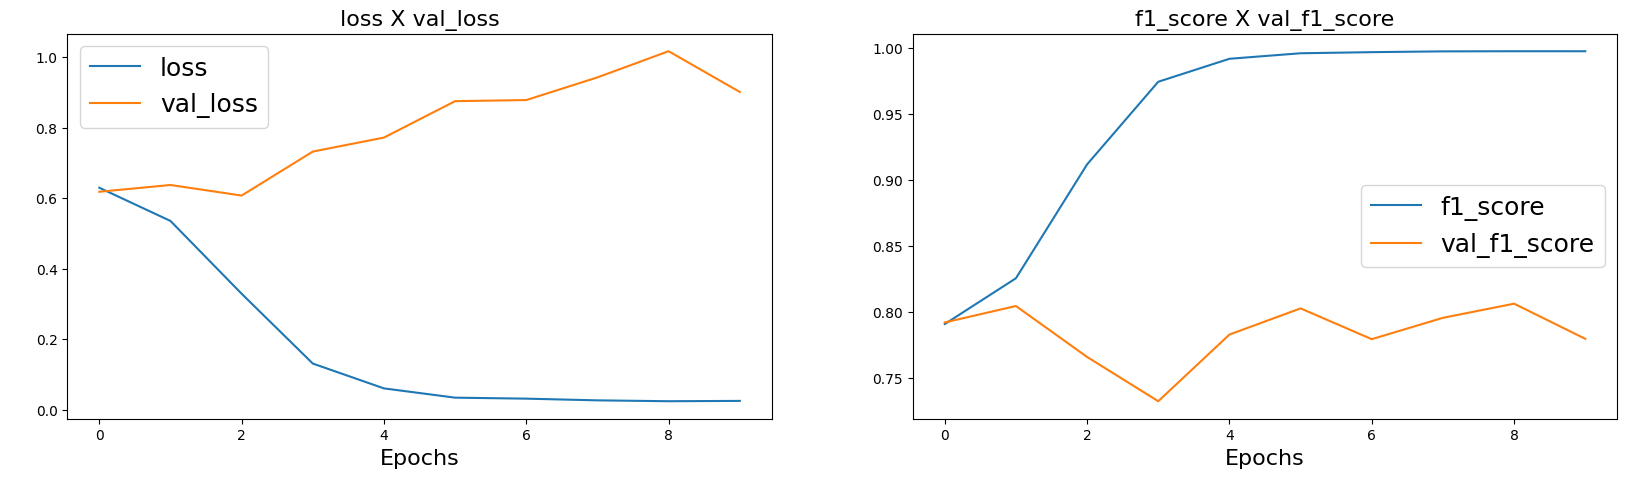

In [ ]:
train_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/train_100.csv"
valid_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/valid.csv"
model_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/100/"

train_method1(train_file=train_file,val_file=valid_file,model_dir=model_dir)

In [ ]:
test_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/test.csv"
model_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/100/model.sav"
output_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/100"

test_method1(test_file=test_file,model_file=model_file,output_dir=output_dir)

Vector saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/100
Model loaded from: /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/100/
27/27 [==============================] - 0s 3ms/step
Accuracy: 0.5942
Recall: 0.5130
Precision: 0.5122
F1-score: 0.5120
Confusion Matrix:
 [[ 79 161]
 [188 432]]
              precision    recall  f1-score   support

           0       0.30      0.33      0.31       240
           1       0.73      0.70      0.71       620

    accuracy                           0.59       860
   macro avg       0.51      0.51      0.51       860
weighted avg       0.61      0.59      0.60       860

Output saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/100/output_test.csv


# Method 2: Hate speech detection using a convolution-LSTM-based deep neural network

# Model Architecture Initialization


In [4]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = os.path.join('./CE807/Assignment2/',str(2205233)) # Make sure to update with your student_id and student_id is an integer
GOOGLE_DRIVE_PATH = os.path.join('gdrive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print('List files: ', os.listdir(GOOGLE_DRIVE_PATH))

train_file = os.path.join(GOOGLE_DRIVE_PATH, 'train.csv')
print('Train file: ', train_file)

MODEL_2_DIRECTORY = os.path.join(GOOGLE_DRIVE_PATH, 'models', '2') # Model 2 directory
print('Model 2 directory: ', MODEL_2_DIRECTORY)

MODEL_2_25_DIRECTORY = os.path.join(MODEL_2_DIRECTORY,'25') # Model 2 trained using 25% of train data directory
print('Model 2 directory with 25% data: ', MODEL_2_25_DIRECTORY)

model_2_25_output_test_file = os.path.join(MODEL_2_25_DIRECTORY, 'output_test.csv') # Output file using Model 2 trained using 25% of train data 
print('Output file name using model 2 using 25% of train data: ',model_2_25_output_test_file)

MODEL_2_50_DIRECTORY = os.path.join(MODEL_2_DIRECTORY,'50') # Model 2 trained using 50% of train data directory
print('Model 2 directory with 50% data: ', MODEL_2_50_DIRECTORY)

model_2_50_output_test_file = os.path.join(MODEL_2_50_DIRECTORY, 'output_test.csv') # Output file using Model 2 trained using 50% of train data 
print('Output file name using model 2 using 50% of train data: ',model_2_50_output_test_file)

MODEL_2_75_DIRECTORY = os.path.join(MODEL_2_DIRECTORY,'75') # Model 2 trained using 75% of train data directory
print('Model 2 directory with 75% data: ', MODEL_2_75_DIRECTORY)

model_2_75_output_test_file = os.path.join(MODEL_2_75_DIRECTORY, 'output_test.csv') # Output file using Model 2 trained using 75% of train data 
print('Output file name using model 2 using 75% of train data: ',model_2_75_output_test_file)

MODEL_2_100_DIRECTORY = os.path.join(MODEL_2_DIRECTORY,'100') # Model 2 trained using 100% of train data directory
print('Model 2 directory with 100% data: ', MODEL_2_100_DIRECTORY)

model_2_100_output_test_file = os.path.join(MODEL_2_100_DIRECTORY, 'output_test.csv') # Output file using Model 2 trained using 100% of train data 
print('Output file name using model 2 using 100% of train data: ',model_2_100_output_test_file)

List files:  ['Code.ipynb', 'valid.csv', 'train.csv', 'test.csv', 'glove.6B', '__pycache__', 'Model1', 'split_data.py', '.ipynb_checkpoints', 'GoogleNews-vectors-negative300.bin.gz', 'Model2', 'train_25.csv', 'train_50.csv', 'train_75.csv', 'train_100.csv', 'preprocessing.py', 'CE807 Assignment 2.gslides']
Train file:  gdrive/MyDrive/./CE807/Assignment2/2205233/train.csv
Model 2 directory:  gdrive/MyDrive/./CE807/Assignment2/2205233/models/2
Model 2 directory with 25% data:  gdrive/MyDrive/./CE807/Assignment2/2205233/models/2/25
Output file name using model 2 using 25% of train data:  gdrive/MyDrive/./CE807/Assignment2/2205233/models/2/25/output_test.csv
Model 2 directory with 50% data:  gdrive/MyDrive/./CE807/Assignment2/2205233/models/2/50
Output file name using model 2 using 50% of train data:  gdrive/MyDrive/./CE807/Assignment2/2205233/models/2/50/output_test.csv
Model 2 directory with 75% data:  gdrive/MyDrive/./CE807/Assignment2/2205233/models/2/75
Output file name using model 2 

In [ ]:
from keras.layers import SpatialDropout1D

def train_method2(train_file, val_file, model_dir):
  #Load train and validation data
    train_data = pd.read_csv(train_file)
    valid_data = pd.read_csv(val_file)
    

    preprocessor = TextPreprocessor()
    train_data = preprocessor.preprocess_dataframe(train_data)
    train_data = preprocessor.map(train_data)
    #train['tweet'] = preprocessor.remove_duplicate_words(train)
   
    
    ##-----valid----##
    valid_data = preprocessor.preprocess_dataframe(valid_data)
    valid_data = preprocessor.map(valid_data)
    #valid['tweet'] = preprocessor.remove_duplicate_words

    train_data = train_data.drop(['id',],axis=True)
    valid_data = valid_data.drop(['id',],axis=True)


    # Convert tweets to padded sequences
    tokenizer = Tokenizer(num_words=100000)
    tokenizer.fit_on_texts(train_data['tweet'])
    word_index = tokenizer.word_index
    X_train = tokenizer.texts_to_sequences(train_data['tweet'])
    X_valid = tokenizer.texts_to_sequences(valid_data['tweet'])
    X_train = pad_sequences(X_train, maxlen=300, padding='post')
    X_valid = pad_sequences(X_valid, maxlen=300, padding='post')

    # Convert labels to numpy arrays
    y_train = np.array(train_data['label'])
    y_valid = np.array(valid_data['label'])

    # Load pre-trained embeddings
    embeddings_index = {}
    with open('/content/gdrive/MyDrive/CE807/Assignment2/2205233/glove.6B/glove.6B.300d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # Create embedding matrix
    embedding_dim = 300
    num_words = min(300000, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    # Create model
    model = Sequential()
    model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=300, trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))


    def f1_score(y_true, y_pred): #taken from old keras source code
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      recall = true_positives / (possible_positives + K.epsilon())
      f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
      return f1_val
    

    # Compile model with F1-score metric
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])
    # Train model
    history = History()
    f1_score = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_valid, y_valid), callbacks=[history])
    
  
    plot_learning_curves(history, [['loss', 'val_loss'],['f1_score', 'val_f1_score']])



    # save model
    joblib.dump(model, model_dir + '/model.sav')
    print(f'model saved to : {model_dir}')






In [ ]:
def test_method2(test_file, model_file, output_dir):
    """
    Load a trained model and evaluate it on a test set, then save the output to a file.

    Args:
        test_file (str): The path to the CSV file containing the test data.
        model_file (str): The path to the saved Keras model file.
        output_dir (str): The path to the directory where the output file should be saved.
    """
     ## Load the test data and model
    test_data = pd.read_csv(test_file)
    ##-----test----##
    preprocessor = TextPreprocessor()
    test_data = preprocessor.preprocess_dataframe(test_data)
    test_data = preprocessor.map(test_data)
    #test['tweet'] = preprocessor.remove_duplicate_words
    test_data = test_data.drop(['id',],axis=True)
    # Convert tweets to padded sequences
    tokenizer = Tokenizer(num_words=100000)
    tokenizer.fit_on_texts(test_data['tweet'])
    word_index = tokenizer.word_index
    X_test = tokenizer.texts_to_sequences(test_data['tweet'])
    X_test = pad_sequences(X_test, maxlen=300, padding='post')
    # Convert labels to numpy arrays
    y_test = np.array(test_data['label'])
    joblib.dump(word_index, output_dir + '/Vectorizer.sav')
    print(f'Vector saved to : {output_dir}')
    model = joblib.load(model_file)
    print(f'Model loaded from: {model_file}')
    # Generate predictions on the test data
    y_pred_prob = model.predict(X_test)
    y_pred = np.round(y_pred_prob).flatten()
    compute_performance(y_test, y_pred)

    # Print the classification report
    print(classification_report(y_test, y_pred))
  
    # Save the output to a file
    test_data['out_label'] = y_pred
    mapping = {1.0: 'NOT', 0.0: 'OFF'}
    test_data['out_label'] = test_data['out_label'].apply(lambda x: mapping[x])
    test_data['label'] = test_data['label'].apply(lambda x: mapping[x])
    test_data.to_csv(output_dir+'/output_test.csv', index=False)
    print(f'Output saved to : {output_dir}/output_test.csv')

  

Training the model using 25% of data i.e. train_25 & Valid file 


Epoch 1/10
25/25 [==============================] - 159s 6s/step - loss: 0.6307 - accuracy: 0.6696 - f1_score: 0.7902 - val_loss: 0.5879 - val_accuracy: 0.6990 - val_f1_score: 0.8072
Epoch 2/10
25/25 [==============================] - 148s 6s/step - loss: 0.5651 - accuracy: 0.7264 - f1_score: 0.8183 - val_loss: 0.5572 - val_accuracy: 0.7357 - val_f1_score: 0.8108
Epoch 3/10
25/25 [==============================] - 149s 6s/step - loss: 0.5300 - accuracy: 0.7401 - f1_score: 0.8247 - val_loss: 0.5514 - val_accuracy: 0.7411 - val_f1_score: 0.8137
Epoch 4/10
25/25 [==============================] - 153s 6s/step - loss: 0.5123 - accuracy: 0.7557 - f1_score: 0.8326 - val_loss: 0.5390 - val_accuracy: 0.7487 - val_f1_score: 0.8138
Epoch 5/10
25/25 [==============================] - 152s 6s/step - loss: 0.5022 - accuracy: 0.7586 - f1_score: 0.8350 - val_loss: 0.5228 - val_accuracy: 0.7573 - val_f1_score: 0.8125
Epoch 6/10
25/25 [==============================] - 150s 6s/step - loss: 0.4651 - acc

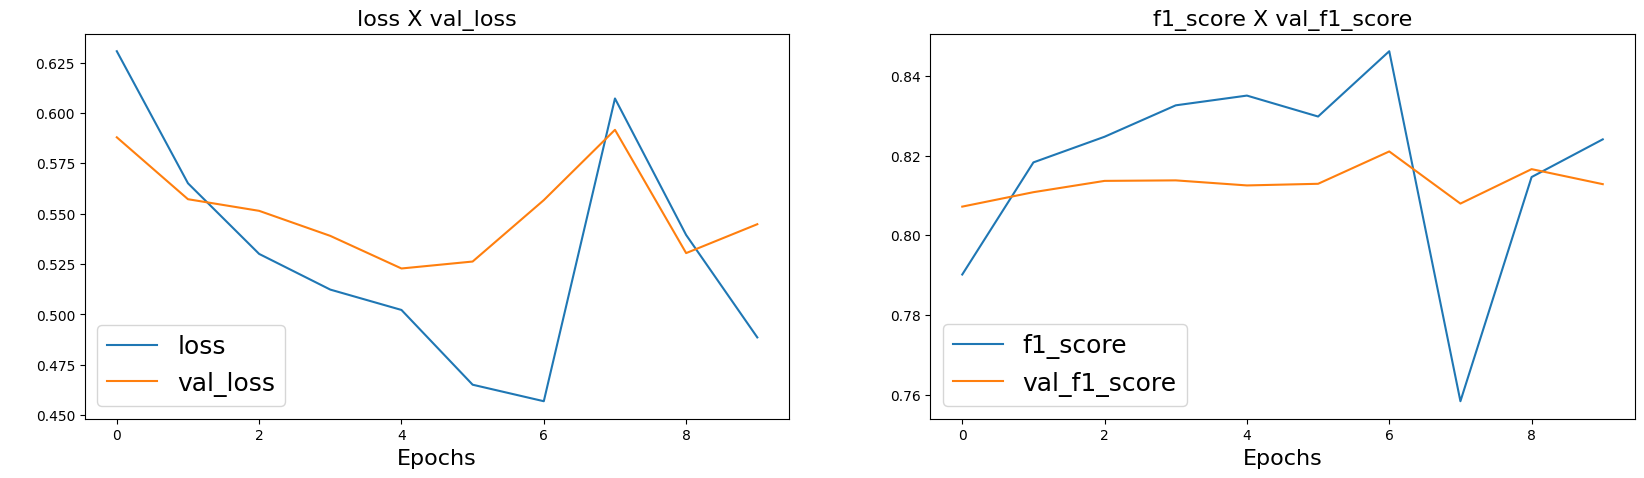

In [ ]:
train_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/train_25.csv"
valid_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/valid.csv"
model_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/25/"

model = train_method2(train_file=train_file,val_file=valid_file,model_dir=model_dir)

In [ ]:
test_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/test.csv"
model_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/25/model.sav"
output_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/25"


test_method2(test_file=test_file,model_file=model_file,output_dir=output_dir)

Vector saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/25


Model loaded from: /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/25/model.sav
27/27 [==============================] - 5s 177ms/step
Accuracy: 0.6233
Recall: 0.5191
Precision: 0.5202
F1-score: 0.5193
Confusion Matrix:
 [[ 68 172]
 [152 468]]
              precision    recall  f1-score   support

           0       0.31      0.28      0.30       240
           1       0.73      0.75      0.74       620

    accuracy                           0.62       860
   macro avg       0.52      0.52      0.52       860
weighted avg       0.61      0.62      0.62       860

Output saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/25/output_test.csv


Training the model using 50% of data i.e. train_50 & Valid file 


Epoch 1/10
49/49 [==============================] - 298s 6s/step - loss: 0.6054 - accuracy: 0.6855 - f1_score: 0.8010 - val_loss: 0.5565 - val_accuracy: 0.7400 - val_f1_score: 0.8072
Epoch 2/10
49/49 [==============================] - 294s 6s/step - loss: 0.5339 - accuracy: 0.7409 - f1_score: 0.8166 - val_loss: 0.5283 - val_accuracy: 0.7476 - val_f1_score: 0.8084
Epoch 3/10
49/49 [==============================] - 291s 6s/step - loss: 0.5122 - accuracy: 0.7503 - f1_score: 0.8230 - val_loss: 0.5114 - val_accuracy: 0.7616 - val_f1_score: 0.8179
Epoch 4/10
49/49 [==============================] - 287s 6s/step - loss: 0.4917 - accuracy: 0.7659 - f1_score: 0.8338 - val_loss: 0.5383 - val_accuracy: 0.7659 - val_f1_score: 0.8304
Epoch 5/10
49/49 [==============================] - 289s 6s/step - loss: 0.4877 - accuracy: 0.7736 - f1_score: 0.8347 - val_loss: 0.5154 - val_accuracy: 0.7638 - val_f1_score: 0.8236
Epoch 6/10
49/49 [==============================] - 292s 6s/step - loss: 0.4775 - acc

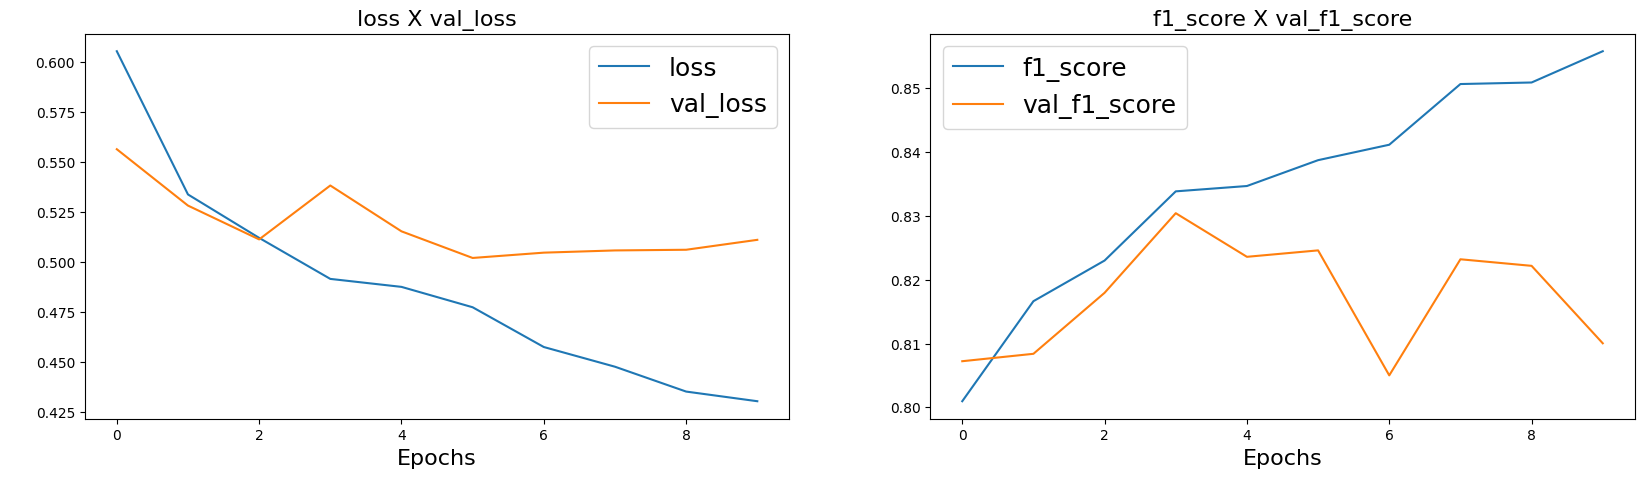

In [ ]:
train_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/train_50.csv"
valid_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/valid.csv"
model_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/50/"

model = train_method2(train_file=train_file,val_file=valid_file,model_dir=model_dir)

In [ ]:
test_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/test.csv"
model_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/50/model.sav"
output_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/50"


test_method2(test_file=test_file,model_file=model_file,output_dir=output_dir)

Vector saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/50


Model loaded from: /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/50/model.sav
27/27 [==============================] - 6s 217ms/step
Accuracy: 0.5895
Recall: 0.4970
Precision: 0.4971
F1-score: 0.4969
Confusion Matrix:
 [[ 69 171]
 [182 438]]
              precision    recall  f1-score   support

           0       0.27      0.29      0.28       240
           1       0.72      0.71      0.71       620

    accuracy                           0.59       860
   macro avg       0.50      0.50      0.50       860
weighted avg       0.60      0.59      0.59       860

Output saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/50/output_test.csv


Training the model using 75% of data i.e. train_75 & Valid file 


Epoch 1/10
73/73 [==============================] - 610s 8s/step - loss: 0.5788 - accuracy: 0.7101 - f1_score: 0.8090 - val_loss: 0.5575 - val_accuracy: 0.7303 - val_f1_score: 0.8130
Epoch 2/10
73/73 [==============================] - 486s 7s/step - loss: 0.5143 - accuracy: 0.7476 - f1_score: 0.8219 - val_loss: 0.5214 - val_accuracy: 0.7443 - val_f1_score: 0.8098
Epoch 3/10
73/73 [==============================] - 464s 6s/step - loss: 0.4889 - accuracy: 0.7652 - f1_score: 0.8350 - val_loss: 0.4985 - val_accuracy: 0.7670 - val_f1_score: 0.8240
Epoch 4/10
73/73 [==============================] - 455s 6s/step - loss: 0.4785 - accuracy: 0.7764 - f1_score: 0.8403 - val_loss: 0.4904 - val_accuracy: 0.7594 - val_f1_score: 0.8191
Epoch 5/10
73/73 [==============================] - 426s 6s/step - loss: 0.4588 - accuracy: 0.7849 - f1_score: 0.8471 - val_loss: 0.5047 - val_accuracy: 0.7605 - val_f1_score: 0.8201
Epoch 6/10
73/73 [==============================] - 423s 6s/step - loss: 0.4521 - acc

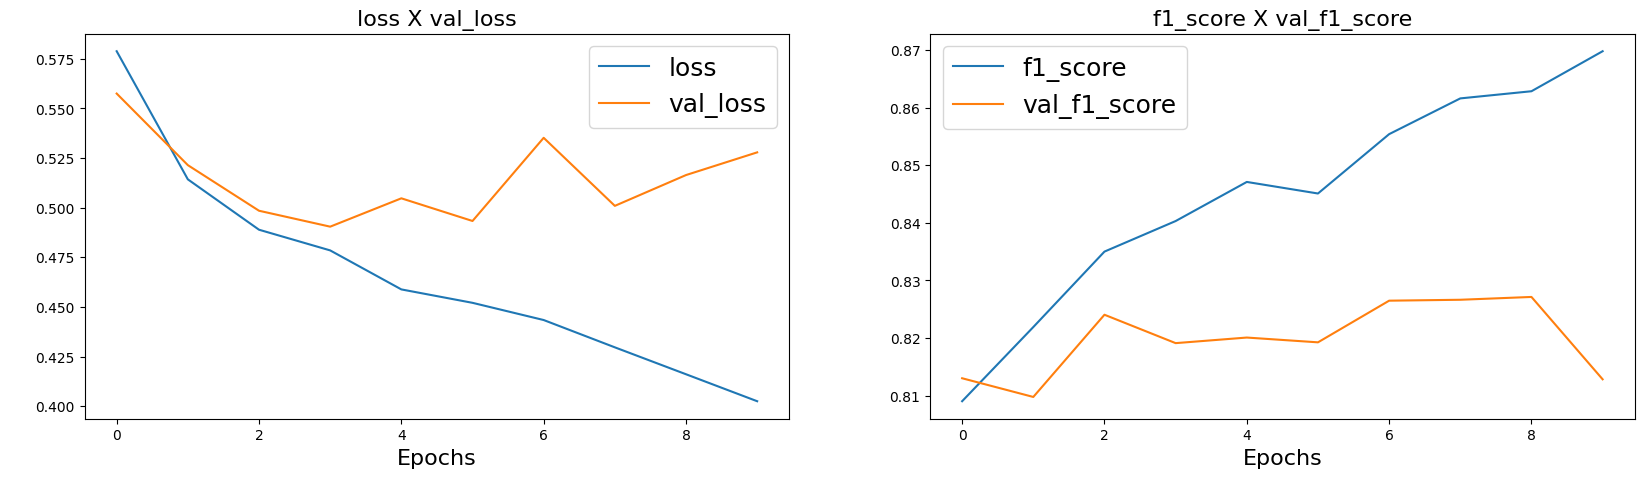

In [ ]:
train_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/train_75.csv"
valid_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/valid.csv"
model_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/75/"

model = train_method2(train_file=train_file,val_file=valid_file,model_dir=model_dir)

In [ ]:
test_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/test.csv"
model_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/75/model.sav"
output_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/75"


test_method2(test_file=test_file,model_file=model_file,output_dir=output_dir)

Vector saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/75


Model loaded from: /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/75/model.sav
27/27 [==============================] - 5s 171ms/step
Accuracy: 0.5709
Recall: 0.4879
Precision: 0.4888
F1-score: 0.4875
Confusion Matrix:
 [[ 72 168]
 [201 419]]
              precision    recall  f1-score   support

           0       0.26      0.30      0.28       240
           1       0.71      0.68      0.69       620

    accuracy                           0.57       860
   macro avg       0.49      0.49      0.49       860
weighted avg       0.59      0.57      0.58       860

Output saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/75/output_test.csv


Training the model using 100% of data i.e. train_100 & Valid file 


Epoch 1/10
97/97 [==============================] - 600s 6s/step - loss: 0.5697 - accuracy: 0.7130 - f1_score: 0.8045 - val_loss: 0.5544 - val_accuracy: 0.7400 - val_f1_score: 0.8150
Epoch 2/10
97/97 [==============================] - 586s 6s/step - loss: 0.5064 - accuracy: 0.7581 - f1_score: 0.8301 - val_loss: 0.5032 - val_accuracy: 0.7519 - val_f1_score: 0.8052
Epoch 3/10
97/97 [==============================] - 591s 6s/step - loss: 0.4890 - accuracy: 0.7683 - f1_score: 0.8362 - val_loss: 0.4979 - val_accuracy: 0.7648 - val_f1_score: 0.8232
Epoch 4/10
97/97 [==============================] - 589s 6s/step - loss: 0.4733 - accuracy: 0.7776 - f1_score: 0.8429 - val_loss: 0.4966 - val_accuracy: 0.7573 - val_f1_score: 0.8184
Epoch 5/10
97/97 [==============================] - 585s 6s/step - loss: 0.4638 - accuracy: 0.7842 - f1_score: 0.8475 - val_loss: 0.5137 - val_accuracy: 0.7648 - val_f1_score: 0.8247
Epoch 6/10
97/97 [==============================] - 580s 6s/step - loss: 0.4518 - acc

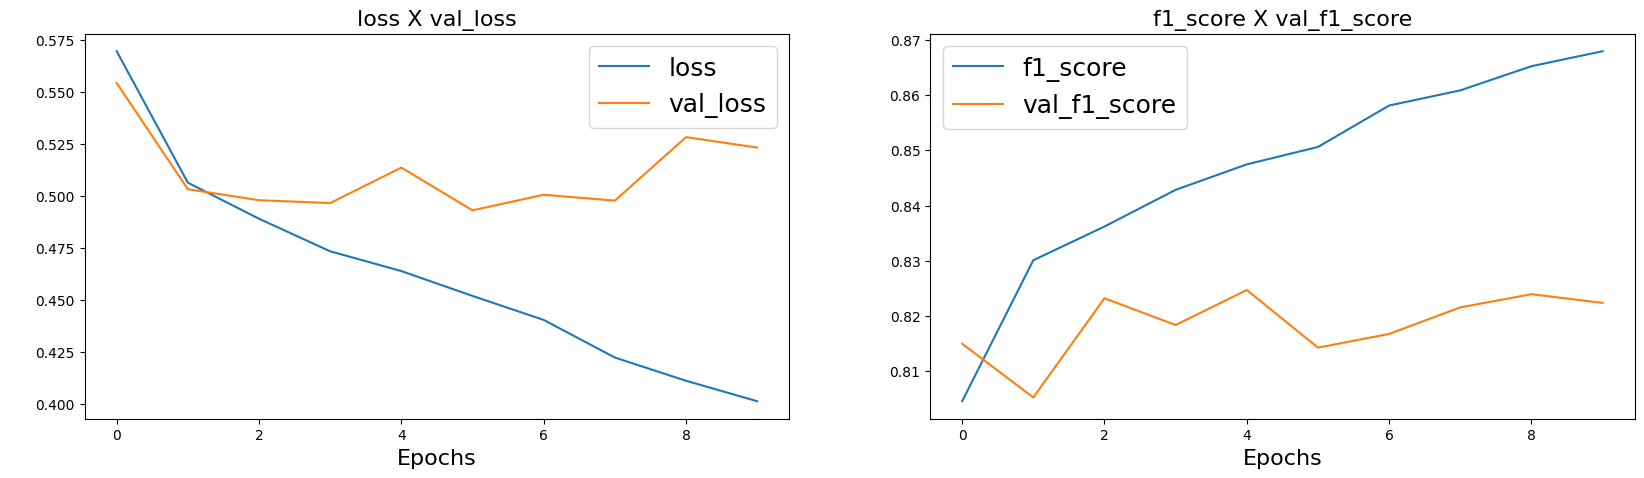

In [ ]:
train_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/train_100.csv"
valid_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/valid.csv"
model_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/100/"

model = train_method2(train_file=train_file,val_file=valid_file,model_dir=model_dir)

In [ ]:
test_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/test.csv"
model_file = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/100/model.sav"
output_dir = "/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/100"


test_method2(test_file=test_file,model_file=model_file,output_dir=output_dir)

Vector saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/100


Model loaded from: /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/100/model.sav
27/27 [==============================] - 6s 218ms/step
Accuracy: 0.5988
Recall: 0.5060
Precision: 0.5059
F1-score: 0.5059
Confusion Matrix:
 [[ 71 169]
 [176 444]]
              precision    recall  f1-score   support

           0       0.29      0.30      0.29       240
           1       0.72      0.72      0.72       620

    accuracy                           0.60       860
   macro avg       0.51      0.51      0.51       860
weighted avg       0.60      0.60      0.60       860

Output saved to : /content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/100/output_test.csv


# 4. Visualization 

# 4.1. Training dataset size

27/27 [==============================] - 5s 161ms/step


27/27 [==============================] - 6s 207ms/step


27/27 [==============================] - 5s 188ms/step


27/27 [==============================] - 5s 164ms/step


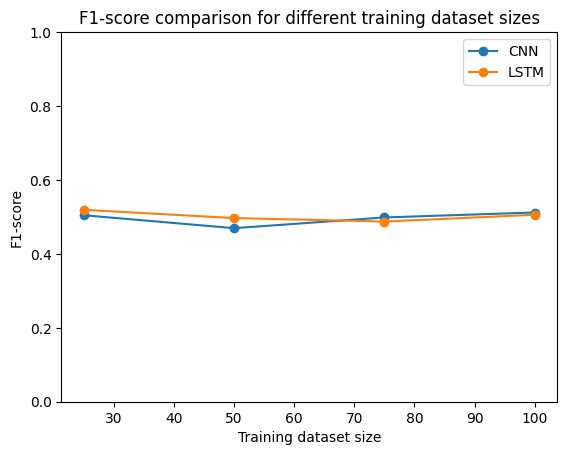

In [ ]:
# Load test data
test_data = pd.read_csv("/content/gdrive/MyDrive/CE807/Assignment2/2205233/test.csv")

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Preprocess test data
test_data = preprocessor.preprocess_dataframe(test_data)
test_data = preprocessor.map(test_data)
test_data = test_data.drop(['id',],axis=True)

# Convert tweets to padded sequences
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(test_data['tweet'])
word_index = tokenizer.word_index
X_test = tokenizer.texts_to_sequences(test_data['tweet'])
X_test = pad_sequences(X_test, maxlen=300, padding='post')

# Convert labels to numpy arrays
y_test = np.array(test_data['label'])

# Dictionary of saved model paths
model_paths = {
    'cnn': {
        25: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/25/model.sav',
        50: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/50/model.sav',
        75: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/75/model.sav',
        100: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/100/model.sav'
    },
    'lstm': {
        25: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/25/model.sav',
        50: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/50/model.sav',
        75: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/75/model.sav',
        100: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/100/model.sav'
    }
}

# List of training dataset sizes to evaluate
train_sizes = [25, 50, 75, 100]

# Initialize lists to store F1-scores
cnn_f1_scores = []
lstm_f1_scores = []

# Iterate through each training dataset size
for size in train_sizes:
    # Load CNN model
    cnn_model_path = model_paths['cnn'][size]
    cnn_model = joblib.load(cnn_model_path)

    # Load LSTM model
    lstm_model_path = model_paths['lstm'][size]
    lstm_model = joblib.load(lstm_model_path)

    # Make predictions using CNN model
    cnn_preds = cnn_model.predict(X_test)
    cnn_preds = np.round(cnn_preds).flatten()
    cnn_f1 = f1_score(y_test, cnn_preds, average='macro')
    cnn_f1_scores.append(cnn_f1)

    # Make predictions using LSTM model
    lstm_preds = lstm_model.predict(X_test)
    lstm_preds = np.round(lstm_preds).flatten()
    lstm_f1 = f1_score(y_test, lstm_preds, average='macro')
    lstm_f1_scores.append(lstm_f1)

# Plot F1-score comparison
plt.plot(train_sizes, cnn_f1_scores, label='CNN', marker='o')
plt.plot(train_sizes, lstm_f1_scores, label='LSTM', marker='o')
plt.title('F1-score comparison for different training dataset sizes')
plt.xlabel('Training dataset size')
plt.ylabel('F1-score')
plt.ylim([0,1])
plt.legend()
plt.show()

# 4.2. Performance Comparison of CNN and LSTM Models.

27/27 [==============================] - 0s 3ms/step
Accuracy: 0.6384
Recall: 0.5079
Precision: 0.5098
F1-score: 0.5045
Confusion Matrix:
 [[ 51 189]
 [122 498]]
27/27 [==============================] - 5s 162ms/step
Accuracy: 0.6233
Recall: 0.5191
Precision: 0.5202
F1-score: 0.5193
Confusion Matrix:
 [[ 68 172]
 [152 468]]


27/27 [==============================] - 0s 3ms/step
Accuracy: 0.5872
Recall: 0.4711
Precision: 0.4690
F1-score: 0.4696
Confusion Matrix:
 [[ 50 190]
 [165 455]]
27/27 [==============================] - 6s 200ms/step
Accuracy: 0.5895
Recall: 0.4970
Precision: 0.4971
F1-score: 0.4969
Confusion Matrix:
 [[ 69 171]
 [182 438]]


27/27 [==============================] - 0s 3ms/step
Accuracy: 0.6012
Recall: 0.4987
Precision: 0.4986
F1-score: 0.4986
Confusion Matrix:
 [[ 64 176]
 [167 453]]
27/27 [==============================] - 5s 164ms/step
Accuracy: 0.5709
Recall: 0.4879
Precision: 0.4888
F1-score: 0.4875
Confusion Matrix:
 [[ 72 168]
 [201 419]]


27/27 [==============================] - 0s 4ms/step
Accuracy: 0.5942
Recall: 0.5130
Precision: 0.5122
F1-score: 0.5120
Confusion Matrix:
 [[ 79 161]
 [188 432]]
27/27 [==============================] - 5s 173ms/step
Accuracy: 0.5988
Recall: 0.5060
Precision: 0.5059
F1-score: 0.5059
Confusion Matrix:
 [[ 71 169]
 [176 444]]


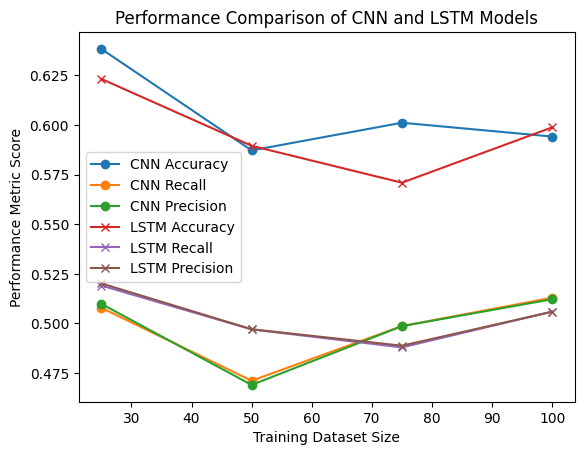

In [ ]:
# Load test data
test_data = pd.read_csv("/content/gdrive/MyDrive/CE807/Assignment2/2205233/test.csv")

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Preprocess test data
test_data = preprocessor.preprocess_dataframe(test_data)
test_data = preprocessor.map(test_data)
test_data = test_data.drop(['id',],axis=True)

# Convert tweets to padded sequences
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(test_data['tweet'])
word_index = tokenizer.word_index
X_test = tokenizer.texts_to_sequences(test_data['tweet'])
X_test = pad_sequences(X_test, maxlen=300, padding='post')

# Convert labels to numpy arrays
y_test = np.array(test_data['label'])

# Dictionary of saved model paths
model_paths = {
    'cnn': {
        25: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/25/model.sav',
        50: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/50/model.sav',
        75: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/75/model.sav',
        100: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model1/100/model.sav'
    },
    'lstm': {
        25: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/25/model.sav',
        50: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/50/model.sav',
        75: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/75/model.sav',
        100: '/content/gdrive/MyDrive/CE807/Assignment2/2205233/Model2/100/model.sav'
    }
}

# List of training dataset sizes to evaluate
train_sizes = [25, 50, 75, 100]

cnn_f1_scores = []
cnn_acc_scores = []
cnn_recall_scores = []
cnn_precision_scores = []
cnn_cm_list = []

lstm_f1_scores = []
lstm_acc_scores = []
lstm_recall_scores = []
lstm_precision_scores = []
lstm_cm_list = []

# Iterate through each training dataset size
for size in train_sizes:
    # Load CNN model
    cnn_model_path = model_paths['cnn'][size]
    cnn_model = joblib.load(cnn_model_path)

    # Load LSTM model
    lstm_model_path = model_paths['lstm'][size]
    lstm_model = joblib.load(lstm_model_path)

     # Make predictions using CNN model
    cnn_preds = cnn_model.predict(X_test)
    cnn_preds = np.round(cnn_preds).flatten()
    cnn_f1, cnn_acc, cnn_recall, cnn_precision, cnn_cm = compute_performance(y_test, cnn_preds)
    cnn_acc_scores.append(cnn_acc)
    cnn_recall_scores.append(cnn_recall)
    cnn_precision_scores.append(cnn_precision)
    cnn_cm_list.append(cnn_cm)

    # Make predictions using LSTM model
    lstm_preds = lstm_model.predict(X_test)
    lstm_preds = np.round(lstm_preds).flatten()
    lstm_f1, lstm_acc, lstm_recall, lstm_precision, lstm_cm = compute_performance(y_test, lstm_preds)
    lstm_acc_scores.append(lstm_acc)
    lstm_recall_scores.append(lstm_recall)
    lstm_precision_scores.append(lstm_precision)
    lstm_cm_list.append(lstm_cm)

# Plot performance metrics comparison

plt.plot(train_sizes, cnn_acc_scores, label='CNN Accuracy', marker='o')
plt.plot(train_sizes, cnn_recall_scores, label='CNN Recall', marker='o')
plt.plot(train_sizes, cnn_precision_scores, label='CNN Precision', marker='o')


plt.plot(train_sizes, lstm_acc_scores, label='LSTM Accuracy', marker='x')
plt.plot(train_sizes, lstm_recall_scores, label='LSTM Recall', marker='x')
plt.plot(train_sizes, lstm_precision_scores, label='LSTM Precision', marker='x')

plt.xlabel('Training Dataset Size')
plt.ylabel('Performance Metric Score')
plt.title('Performance Comparison of CNN and LSTM Models')
plt.legend()
plt.show()




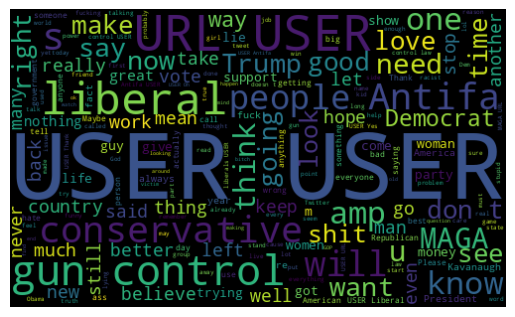

In [10]:
allwords = " ".join( [reve for reve in train['tweet']])
wordcloud = WordCloud(width=500,height=300,random_state=45,max_font_size=120).generate(allwords)

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

In [11]:
mapping = {'NOT':1 , 'OFF':0}
train['label'].replace(mapping,inplace=True)

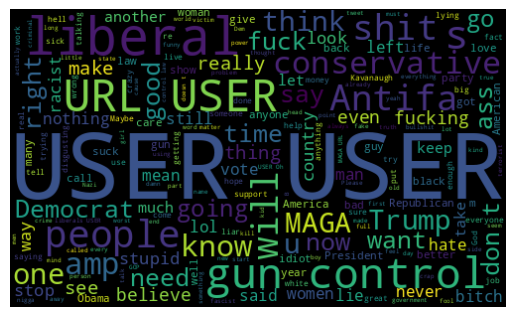

In [12]:
negative_data = train[train.label == 0]['tweet']
allwords = " ".join( [reve for reve in negative_data])
wordcloud = WordCloud(width=500,height=300,random_state=45,max_font_size=120).generate(allwords)

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

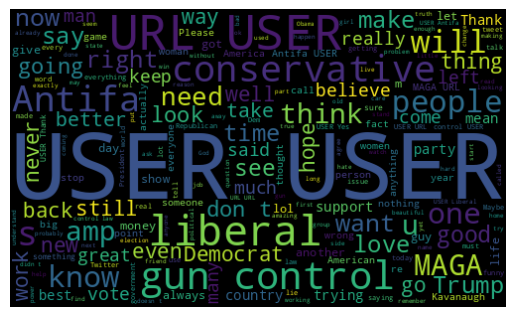

In [13]:
postive_data = train[train.label == 1]['tweet']
allwords = " ".join( [reve for reve in postive_data])
wordcloud = WordCloud(width=500,height=300,random_state=45,max_font_size=120).generate(allwords)

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()